#### Import Necessary Libraries ####

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### read all the data ####

In [5]:
filepath = 'F:/vedantu/assignment/assignment/data_sets'

#import data files
customer_feature = pd.read_csv(filepath + "/customer_features.csv")
last_month_assort = pd.read_csv(filepath + "/last_month_assortment.csv")
next_month_assort = pd.read_csv(filepath + "/next_month_assortment.csv")
next_purchase_order = pd.read_csv(filepath + "/next_purchase_order.csv")
original_purchase_order = pd.read_csv(filepath + "/original_purchase_order.csv")
product_features = pd.read_csv(filepath + "/product_features.csv")

print("customer features dataframe shape:{}".format(customer_feature.shape))
print("last month assortment dataframe shape:{}".format(last_month_assort.shape))
print("next month assortment dataframe shape:{}".format(next_month_assort.shape))
print("next purchase order dataframe shape:{}".format(next_purchase_order.shape))
print("original purchase order dataframe shape:{}".format(original_purchase_order.shape))
print("product features dataframe shape:{}".format(product_features.shape))

customer features dataframe shape:(12000, 4)
last month assortment dataframe shape:(36000, 3)
next month assortment dataframe shape:(56400, 2)
next purchase order dataframe shape:(300, 4)
original purchase order dataframe shape:(1000, 4)
product features dataframe shape:(1000, 5)


#### check what is the loan amount? ####

there is no missing (or) null information in the "original_purchase_order.csv" file

In [25]:
original_purchase_order['total_cost']=original_purchase_order[['quantity_purchased', 'cost_to_buy']].apply(lambda row: row['quantity_purchased'] * row['cost_to_buy'], axis=1)

loan_amount = original_purchase_order['total_cost'].sum()

print("total loan amount:{}".format(loan_amount))

total loan amount:135546.41999999998


#### check next purchase order total amount ? ####

there are no missing value (or) null information in the "next_purchase_order.csv" file

In [28]:
next_purchase_order['total_cost'] = next_purchase_order[['quantity_purchased', 'cost_to_buy']].apply(lambda row: row['quantity_purchased'] * row['cost_to_buy'], axis=1)

next_purchase_order_amount = next_purchase_order['total_cost'].sum()

print("amount spent for next purchase order:{}".format(next_purchase_order_amount))

amount spent for next purchase order:24155.510000000002


#### money made back from customer ####

In [45]:
#get only product_id where book the is purchased or not
onlypurchasedBook = last_month_assort[last_month_assort['purchased'] == True]

#check the retail price for all those books and do sum 
#to check what money we made back from the customer

orgpo_copy = original_purchase_order.copy() #original purchase order copy
orgpo_copy = orgpo_copy.set_index(original_purchase_order.product_id)

moneymadeback = orgpo_copy.loc[onlypurchasedBook['product_id'].tolist()]['retail_value'].sum()
print("total money made back by selling books:{}".format(moneymadeback))

#see the shipping charge
shippingcharge = last_month_assort.shape[0] * 0.60
print("total shipping charge for last month:{}".format(shippingcharge))

total money made back by selling books:151617.36
total shipping charge for last month:21600.0


### preprocess dataset ###

#### check genres from the customer_features.csv dataset ####

In [223]:
uniqueGenres = []
genresFreq = []

for genres in customer_feature['favorite_genres']:
    #replace the word 
    word = genres.replace("[","")
    word = word.replace("]","")
    word = word.replace("'","")
    #split by comma
    wordslist = word.split(",")
    #iterate through the list
    if len(wordslist) != 0:
        for genr in wordslist:
            genresFreq.append(genr)
            if genr not in uniqueGenres:
                uniqueGenres.append(genr)
            else:
                pass

print("total number of genres:{}".format(len(uniqueGenres)))

total number of genres:23


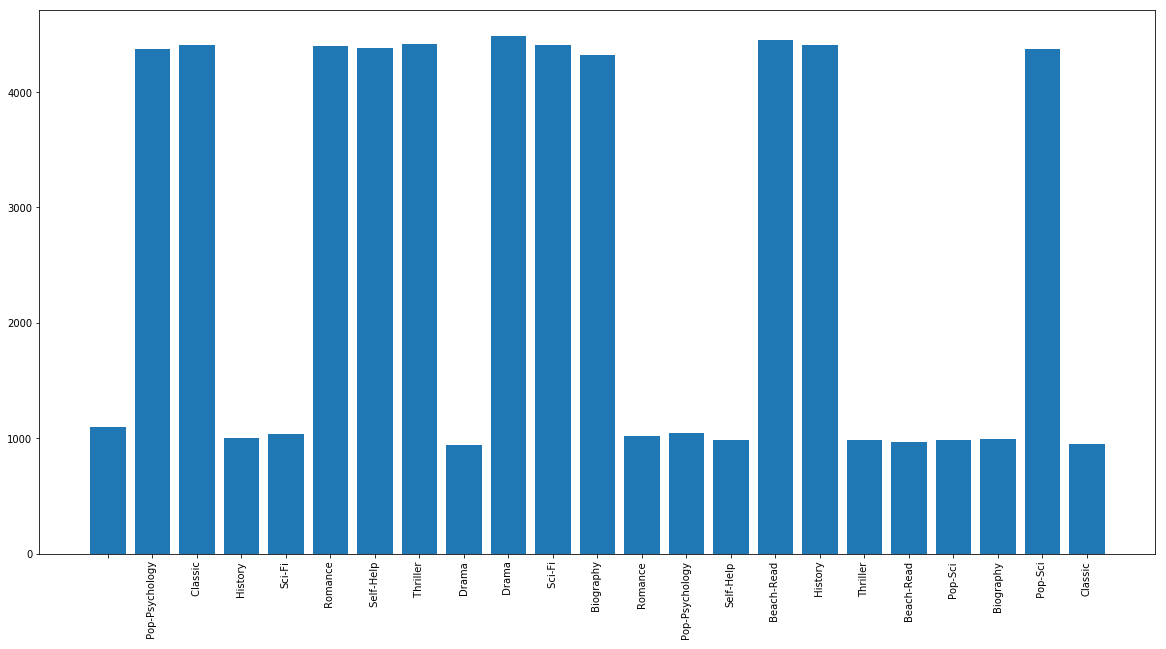

In [64]:
from collections import Counter
frequency = Counter(genresFreq)

plt.figure(figsize=(20, 10))
plt.bar(range(len(frequency)), list(frequency.values()), align='center')
plt.xticks(range(len(frequency)), list(frequency.keys()), rotation='vertical')

plt.show()

from the above graph we can see, what are the top picks for the customers.

#### convert favorite genres to one hot encoding ####

In [103]:
#get total length of the customers
def convertIntoList(genaslist):
     #replace the word 
    word = genaslist.replace("[","")
    word = word.replace("]","")
    word = word.replace("'","")
    #split by comma
    wordslist = word.split(",")
    
    return wordslist

def oneHotEncode(df):
    no_of_customers = []
    
    #get index of each uniqueGenres that customer likes
    df = df.reset_index(0)
    for row in range(df.shape[0]):
        genre_list = [0]*len(uniqueGenres)
        #get the subsetdf
        subsetdf = df.iloc[row]['favorite_genres']
        genlist = convertIntoList(subsetdf)
        
        #get the index for unique
        indexlist = [uniqueGenres.index(genre) for genre in genlist]
        
        for ind in indexlist:
            genre_list[ind] = 1
        
        no_of_customers.append(genre_list)
    
    return no_of_customers

onehotfeatures = oneHotEncode(customer_feature)

In [111]:
#convert above feature into the dataframe
onehotdf = pd.DataFrame(onehotfeatures, columns=uniqueGenres)
onehotdf.shape

(12000, 23)

In [112]:
#concatenate the above dataframe with customer_features
concat_customerfeature = pd.concat([customer_feature, onehotdf], axis=1)
concat_customerfeature.shape
#drop favorite_genres feature in the dataset
concat_customerfeature = concat_customerfeature.drop(['favorite_genres'], axis=1)

In [115]:
#see favorite genre by age_bucket
age_gby = concat_customerfeature.groupby(['age_bucket']).agg(['sum'])
age_gby = pd.DataFrame(age_gby)
age_gby = age_gby.drop(['customer_id', 'is_returning_customer'], axis=1)
age_gby.to_csv("ageWiseinsights.csv", sep=",")

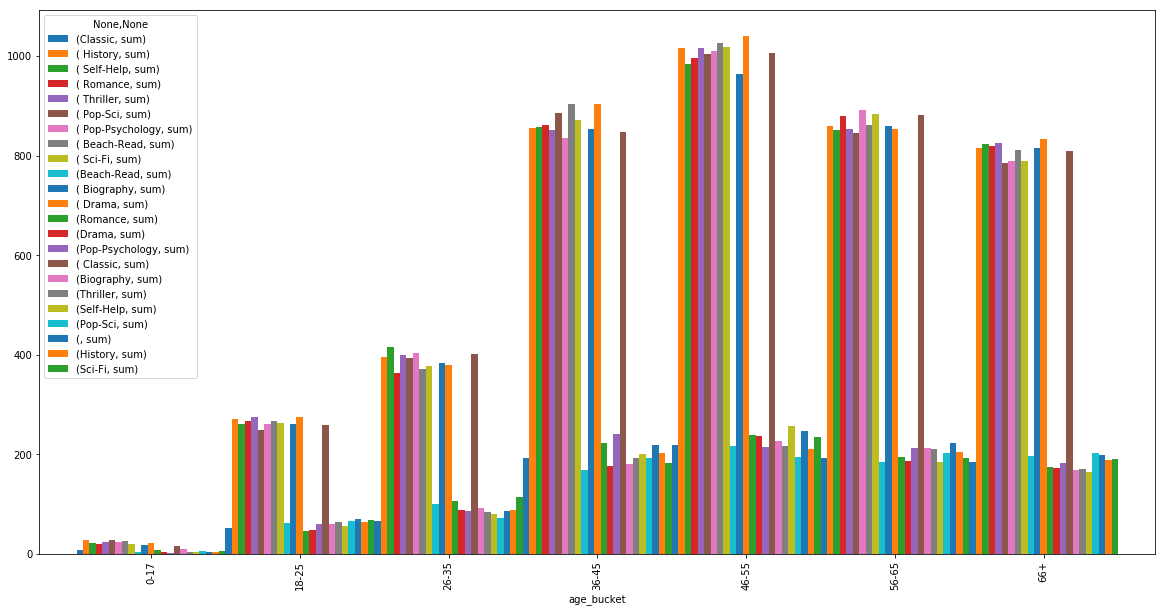

In [124]:
age_gby.plot.bar(figsize=(20, 10), width=1.0)
plt.show()

from the above observation w.k.t age bucket between 46-55 read of lot of books.

In [127]:
concat_customerfeature.columns = ['customer_id','age_bucket',
 'is_returning_customer','Classic',' History',' Self-Help',' Romance',' Thriller',' Pop-Sci',
 ' Pop-Psychology',' Beach-Read',' Sci-Fi','Beach-Read',' Biography',' Drama','Romance',
 'Drama','Pop-Psychology',' Classic','Biography','Thriller','Self-Help',
 'Pop-Sci','notKnown','History','Sci-Fi']

concat_customerfeature.head()

,customer_id,age_bucket,is_returning_customer,Classic,History,Self-Help,Romance,Thriller,Pop-Sci,Pop-Psychology,...,Drama,Pop-Psychology,Classic,Biography,Thriller,Self-Help,Pop-Sci,notKnown,History,Sci-Fi
0,1000078,46-55,True,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1000102,46-55,True,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1000185,46-55,True,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1000423,26-35,True,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000696,66+,True,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0


#### check in last_month_assortment what type of books sold  ####

In [148]:
prdfeat_copy = product_features.copy() #copy dataframe for product features
prdfeat_copy = prdfeat_copy.set_index('product_id')

from collections import defaultdict 

prdfeatures_dict = defaultdict(int)

for k, v in zip(prdfeat_copy.index.tolist(),  prdfeat_copy.to_dict(orient='records')):
    prdfeatures_dict[k] = v

In [165]:
lsma_copy = last_month_assort.copy() #copy of last month assort
lsma_copy['fiction'] = lsma_copy.apply(lambda row: prdfeatures_dict[row['product_id']]['fiction'], axis=1)
lsma_copy['genre'] = lsma_copy.apply(lambda row: prdfeatures_dict[row['product_id']]['genre'], axis=1)

In [170]:
lsma_copy.groupby(['purchased', 'fiction']).agg(['count'])

customer_id product_id  genre
                        count      count  count
purchased fiction                              
False     False          9139       9139   9139
          True          14182      14182  14182
True      False          3442       3442   3442
          True           9237       9237   9237

In [175]:
lsma_copy.head()

,customer_id,product_id,purchased,fiction,genre
0,1000078,1730073,False,True,Drama
1,1000078,1470520,False,True,Romance
2,1000078,1861356,False,True,Thriller
3,1000078,1240824,True,True,Classic
4,1000078,1155460,False,True,Thriller


In [172]:
concat_customerfeature[concat_customerfeature['customer_id'] == 1000078]

,customer_id,age_bucket,is_returning_customer,Classic,History,Self-Help,Romance,Thriller,Pop-Sci,Pop-Psychology,...,Drama,Pop-Psychology,Classic,Biography,Thriller,Self-Help,Pop-Sci,notKnown,History,Sci-Fi
0,1000078,46-55,True,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


####  left join lsma_copy and feature intrest ####

In [177]:
#left dataframe = lsma_copy
#right dataframe = concat_customerfeature
left_join = pd.merge(lsma_copy, concat_customerfeature, on='customer_id', how='left')
left_join.shape

(36000, 30)

In [190]:
#get the book price from the product_features.csv files
nrows = left_join.shape[0]
retail_price = []

for i in range(nrows):
    #get the data
    subsetdf = left_join.iloc[i]['product_id']
    #locate the retail price in orgpo_copy data
    rp = orgpo_copy[orgpo_copy['product_id'] == subsetdf]['retail_value'].values[0]
    retail_price.append(rp)

In [191]:
left_join['retailPrice'] = retail_price #set the column in the dataframe

#### check if we have all customer interest data in the customer_features.csv file ####

In [197]:
nextmonth_customer = next_month_assort.customer_id.unique().tolist()
customer_lookup = customer_feature.customer_id.unique().tolist()

In [198]:
[x for x in nextmonth_customer if x not in customer_lookup]

[]

So, in the test data we have all customer id which is also present in the customer feature lookup data

#### sample modeling  ####

try the models with the data we have!

In [231]:
#convert categorical variable to label encoding
def label_encoding(asSeries):
    encoding = []
    #get unique values
    uniqueList = sorted(asSeries.unique().tolist())
    #iterate through the asSeries
    for ser in asSeries:
        #get index of that value in uniqueList
        index = uniqueList.index(ser)
        encoding.append(index)
        
    return encoding

target_label = label_encoding(left_join['purchased'])
fiction_label = label_encoding(left_join['fiction'])
isReturning_label = label_encoding(left_join['is_returning_customer'])
genre_label = label_encoding(left_join['genre'])

In [232]:
left_join['age_bucket'] = left_join['age_bucket'].fillna('')
age_label = label_encoding(left_join['age_bucket'])

In [235]:
#split the dataset
input_features = ['Classic',' History',' Self-Help',' Romance',' Thriller',' Pop-Sci',
 ' Pop-Psychology',' Beach-Read',' Sci-Fi','Beach-Read',' Biography',' Drama','Romance',
 'Drama','Pop-Psychology',' Classic','Biography','Thriller','Self-Help',
 'Pop-Sci','notKnown','History','Sci-Fi', 'retailPrice', 'fiction_label', 'isReturning_label',
 'genre_label', 'age_label']

target = 'target_label'

#add all those column in the dataset
left_join['fiction_label'] = fiction_label
left_join['target_label'] = target_label
left_join['isReturning_label'] = isReturning_label
left_join['age_label'] = age_label
left_join['genre_label'] = genre_label

#split input and output
X, y = left_join[input_features], left_join[target]

In [236]:
y.value_counts()

0    23321
1    12679
Name: target_label, dtype: int64

In [239]:
#split the dataset into train and validate
from sklearn.model_selection import train_test_split

X_train, evalX, y_train, evalY = train_test_split(
    X, y, test_size = 0.1,
    random_state=12)

print(X_train.shape, y_train.shape, evalX.shape, evalY.shape)

(32400, 28) (32400,) (3600, 28) (3600,)


### xgb classifier ###

In [248]:
import xgboost as xgb 
from sklearn.metrics import accuracy_score, roc_auc_score

def xgb_model(train_data, train_label, test_data, test_label):
    clf = xgb.XGBClassifier(max_depth=7,
                           min_child_weight=1,
                           learning_rate=0.1,
                           n_estimators=500,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)
    clf.fit(train_data, train_label, eval_metric='auc', verbose=True,
            eval_set=[(test_data, test_label)], early_stopping_rounds=100)
    y_pre = clf.predict(test_data)
    y_pro = clf.predict_proba(test_data)[:, 1]
    
    print("AUC Score:{}".format(roc_auc_score(test_label, y_pro)))
    print("Accuracy:{}".format(accuracy_score(test_label, y_pre)))
    
    return clf, y_pre
          

xgb_clf, xgb_prediction = xgb_model(X_train, y_train, evalX, evalY)

[0]	validation_0-auc:0.637307
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.641224
[2]	validation_0-auc:0.647101
[3]	validation_0-auc:0.655037
[4]	validation_0-auc:0.657066
[5]	validation_0-auc:0.660584
[6]	validation_0-auc:0.663451
[7]	validation_0-auc:0.66312
[8]	validation_0-auc:0.665827
[9]	validation_0-auc:0.667415
[10]	validation_0-auc:0.667792
[11]	validation_0-auc:0.66904
[12]	validation_0-auc:0.66944
[13]	validation_0-auc:0.670447
[14]	validation_0-auc:0.671376
[15]	validation_0-auc:0.673236
[16]	validation_0-auc:0.672604
[17]	validation_0-auc:0.674707
[18]	validation_0-auc:0.675876
[19]	validation_0-auc:0.678005
[20]	validation_0-auc:0.678577
[21]	validation_0-auc:0.678978
[22]	validation_0-auc:0.680078
[23]	validation_0-auc:0.68131
[24]	validation_0-auc:0.68625
[25]	validation_0-auc:0.687066
[26]	validation_0-auc:0.687617
[27]	validation_0-auc:0.693913
[28]	validation_0-auc:0.69387
[29]	validation_0-auc:0.694164
[30]	validation_0-auc

[259]	validation_0-auc:0.772915
[260]	validation_0-auc:0.77285
[261]	validation_0-auc:0.773106
[262]	validation_0-auc:0.773364
[263]	validation_0-auc:0.773158
[264]	validation_0-auc:0.773219
[265]	validation_0-auc:0.773113
[266]	validation_0-auc:0.773082
[267]	validation_0-auc:0.773231
[268]	validation_0-auc:0.773464
[269]	validation_0-auc:0.773813
[270]	validation_0-auc:0.773574
[271]	validation_0-auc:0.773488
[272]	validation_0-auc:0.773416
[273]	validation_0-auc:0.77348
[274]	validation_0-auc:0.77338
[275]	validation_0-auc:0.77341
[276]	validation_0-auc:0.773297
[277]	validation_0-auc:0.773204
[278]	validation_0-auc:0.773031
[279]	validation_0-auc:0.772847
[280]	validation_0-auc:0.773012
[281]	validation_0-auc:0.773017
[282]	validation_0-auc:0.773076
[283]	validation_0-auc:0.773128
[284]	validation_0-auc:0.773289
[285]	validation_0-auc:0.773538
[286]	validation_0-auc:0.773628
[287]	validation_0-auc:0.773795
[288]	validation_0-auc:0.773766
[289]	validation_0-auc:0.773656
[290]	valida

In [250]:
predictiondf = pd.DataFrame({'actual': evalY, 'prediction':xgb_prediction})

In [251]:
predictiondf.to_csv("prediction.csv", sep=",")

####  checking model stability ####

In [252]:
from imblearn.metrics import classification_report_imbalanced

print("XGB Model Metrics")
print(classification_report_imbalanced(evalY, xgb_prediction))

XGB Model Metrics
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.87      0.49      0.80      0.65      0.44      2285
          1       0.68      0.49      0.87      0.57      0.65      0.41      1315

avg / total       0.72      0.73      0.63      0.72      0.65      0.43      3600

